In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="economicsmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
economicsFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
economicsFOSID = economicsFOSID.filter(economicsFOSID["Domain"]=="Economics").collect()

In [8]:
len(economicsFOSID)

547

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(economicsFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+---------+
|   FOS_ID|   Domain|
+---------+---------+
|112930515|Economics|
|149923435|Economics|
+---------+---------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

10870691

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [20]:
(sample1,sample2) = papers_filtered1.randomSplit([0.1,0.8])

In [21]:
sample1.count()

1208229

In [22]:
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [23]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             0|
|             0|
|             0|
|             0|
+--------------+
only showing top 4 rows



In [24]:
sample1_pd = sample1.toPandas()

In [25]:
import numpy as np

In [26]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [27]:
from sklearn import metrics

In [28]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 2.7421060080497983)
('Mean Squared Error of EstimatedCount:', 6616.035691909398)
('Root Mean Squared of with EstimatedCount:', 81.33901703309057)


In [29]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [30]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [32]:
from sklearn.model_selection import KFold

In [33]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 2.1662770407097827)
('Mean Squared Error:', 453.94763333626565)
('Root Mean Squared Error:', 21.30604687257272)
('Mean Absolute Error:', 1.8668518542783668)
('Mean Squared Error:', 351.95687287613396)
('Root Mean Squared Error:', 18.760513662374333)
('Mean Absolute Error:', 2.1577870658065277)
('Mean Squared Error:', 1134.1335768252964)
('Root Mean Squared Error:', 33.67689975079797)
('Mean Absolute Error:', 2.1278270016450977)
('Mean Squared Error:', 571.0568509948524)
('Root Mean Squared Error:', 23.896795831132934)
('Mean Absolute Error:', 1.4596697850960192)
('Mean Squared Error:', 1066.8760539278367)
('Root Mean Squared Error:', 32.66306865448861)


In [36]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 26.060664954273314)


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
featureslist=sample1_pd.columns

In [39]:
importances = regressor.feature_importances_

In [40]:
import pandas as pd

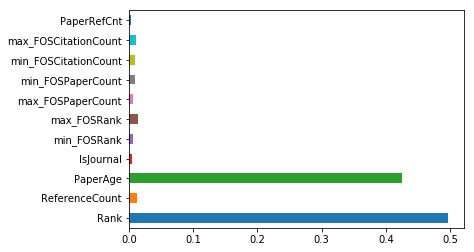

In [41]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model

In [42]:
import xgboost as xgb

In [43]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [44]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 241646,  241647,  241648, ..., 1208226, 1208227, 1208228]), 'TEST:', array([     0,      1,      2, ..., 241643, 241644, 241645]))
('Mean Absolute Error of XGBoost Kfold:', 2.3493951726956586)
('Mean Squared Error of XGBoost Kfold:', 1408.6801153359768)
('Root Mean Squared Error of XGBoost Kfold:', 37.532387551766234)
('TRAIN:', array([      0,       1,       2, ..., 1208226, 1208227, 1208228]), 'TEST:', array([241646, 241647, 241648, ..., 483289, 483290, 483291]))
('Mean Absolute Error of XGBoost Kfold:', 2.0142226205752722)
('Mean Squared Error of XGBoost Kfold:', 824.6155012686721)
('Root Mean Squared Error of XGBoost Kfold:', 28.716119188857537)
('TRAIN:', array([      0,       1,       2, ..., 1208226, 1208227, 1208228]), 'TEST:', array([483292, 483293, 483294, ..., 724935, 724936, 724937]))
('Mean Absolute Error of XGBoost Kfold:', 2.2489712748061397)
('Mean Squared Error of XGBoost Kfold:', 1124.5726758421004)
('Root Mean Squared Error of XGBoost Kfold:', 33.5

In [45]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 31.821265124277488)


In [46]:
importances = regressor.feature_importances_

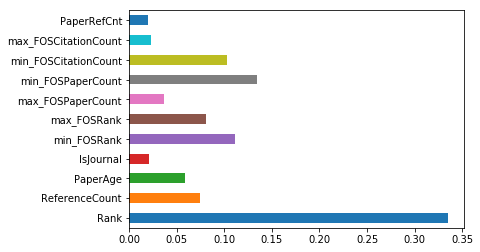

In [47]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [48]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.33485
Feature: 1, Score: 0.07510
Feature: 2, Score: 0.05852
Feature: 3, Score: 0.02120
Feature: 4, Score: 0.11124
Feature: 5, Score: 0.08132
Feature: 6, Score: 0.03654
Feature: 7, Score: 0.13483
Feature: 8, Score: 0.10347
Feature: 9, Score: 0.02288
Feature: 10, Score: 0.02004


In [30]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [31]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

In [33]:
from sklearn import metrics
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('TRAIN:', array([  23768,   34914,   35126, ..., 2174191, 2174192, 2174193]), 'TEST:', array([      0,       1,       2, ..., 2159952, 2171509, 2173182]))
('Mean Absolute Error:', 5.949280055687577)
('Mean Squared Error:', 10379.061088653152)
('Root Mean Squared Error:', 101.8776770870496)
('TRAIN:', array([      0,       1,       2, ..., 2174191, 2174192, 2174193]), 'TEST:', array([  23768,   34914,   35126, ..., 2129262, 2159922, 2159923]))
('Mean Absolute Error:', 4.633791164619073)
('Mean Squared Error:', 497.5076613690275)
('Root Mean Squared Error:', 22.30487976585006)
('TRAIN:', array([      0,       1,       2, ..., 2174191, 2174192, 2174193]), 'TEST:', array([  92202,  136785,  137423, ..., 2129237, 2129241, 2159926]))
('Mean Absolute Error:', 4.548931450654503)
('Mean Squared Error:', 355.0415171536141)
('Root Mean Squared Error:', 18.842545400067745)
('TRAIN:', array([      0,       1,       2, ..., 2174191, 2174192, 2174193]), 'TEST:', array([ 275195,  370536,  370708, ...

In [34]:
rmse_list

[101.8776770870496,
 22.30487976585006,
 18.842545400067745,
 16.735595469987558,
 16.79947649718472]

In [35]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 35.312034844027934)


In [36]:
import xgboost as xgb

In [37]:
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=3
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([  23768,   34914,   35126, ..., 2174191, 2174192, 2174193]), 'TEST:', array([      0,       1,       2, ..., 2159952, 2171509, 2173182]))
('Mean Absolute Error:', 4.14947807428083)
('Mean Squared Error:', 8108.059212051534)
('Root Mean Squared Error:', 90.0447622688379)
('TRAIN:', array([      0,       1,       2, ..., 2174191, 2174192, 2174193]), 'TEST:', array([  23768,   34914,   35126, ..., 2129262, 2159922, 2159923]))
('Mean Absolute Error:', 2.8374867180176166)
('Mean Squared Error:', 196.87616638989186)
('Root Mean Squared Error:', 14.031256764448859)
('TRAIN:', array([      0,       1,       2, ..., 2174191, 2174192, 2174193]), 'TEST:', array([  92202,  136785,  137423, ..., 2129237, 2129241, 2159926]))
('Mean Absolute Error:', 2.7777759943312947)
('Mean Squared Error:', 152.18036605531404)
('Root Mean Squared Error:', 12.336140646706086)
('TRAIN:', array([      0,       1,       2, ..., 2174191, 2174192, 2174193]), 'TEST:', array([ 275195,  370536,  370708, .

In [38]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 27.92693649841443)
